# Generative Adversarial Network


##Ý tưởng chính:
Huấn luyện đồng thời hai mô hình
> * Generator G: Học cách sinh dữ liệu giống thật nhất để đánh lừa discriminator
* Discriminator D: đánh giá và phân biệt đâu là dữ liệu thực và đâu là dữ liệu giả được tạo ra bởi generator

Quá trình huấn luyện sẽ diễn ra cho đến khi Discriminator D không thể phân biệt được thật giả, xác suất D bằng 1/2 ở mọi nơi.


In [27]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

In [28]:
# number of subprocesses to use for data loading
num_workers = 0
# number of samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# MNIST dataset
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
# FashionMNIST dataset
  # train_data = datasets.FashionMNIST(root='data', train=True,download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

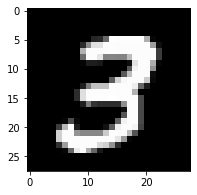

In [29]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[7])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Cài đặt mô hình


### Discriminator
* Xây dựng tất cả lớp ẩn là Linear layer
* Sử dụng kĩ thuật Dropout với hệ số 0.3 để bỏ qua một số neural giúp tăng khả năng học của mô hình và tránh overfitting
* Hàm forward truyền dữ liệu hình ảnh x đã được flatten qua các layer
* Sử dụng Leaky ReLU làm hàm kích hoạt trừ lớp cuối cùng không sử dụng bất kì hàm kích hoạt nào.

Discriminator khi có input đầu vào sẽ cho kết quả là 0 hoặc 1 cho biết hình ảnh là thật hay giả.

In [30]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        out = self.fc4(x)

        return out


### Generator
Tương tự khi xây dựng Discriminator nhưng layer cuối sử dụng hàm tanh để tỉ lệ output nằm trong khoảng [-1,1]


In [31]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer should have tanh applied
        out = F.tanh(self.fc4(x))
        
        return out

## Các tham số mô hình

In [32]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of generator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 32

## Xây dựng mạng GAN hoàn chỉnh


In [33]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---
## Hàm loss của Discriminator và Generator


### Discriminator
Mục tiêu: mong muốn D(real_images) = 1 và D(fake_images) = 0
* Tổng loss của Discriminator là `d_loss = d_real_loss + d_fake_loss`. 
* Sử dụng BCEWithLoss (kết hợp Binary cross entropy và kích hoạt sigmoid)
* Làm mịn nhãn nếu tham số smooth=true bằng việc giảm từ 1.0 xuống 0.9.


### Generator

Mục tiêu: làm cho D(fake_image) = 1
Các nhãn được lật thể hiện generator đang cố gắng đánh lừa discriminator với ảnh mà nó tạo ra

In [34]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
      labels = torch.ones(batch_size)*0.9
    else:
      labels = torch.ones(batch_size)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    # compare logits to fake labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Sử dụng thuật toán tối ưu Adam cho riêng D và riêng G, là một phương pháp tối ưu hóa dựa trên gradient bậc nhất của các hàm mục tiêu ngẫu nhiên, nó có hiệu quả về mặt tính toán và yêu cầu ít bộ nhớ.

In [35]:
# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Huấn luyện

Huấn luyện xen kẽ k lần Discriminator và 1 lần Generator. Ở đây k = 1.

### Huấn luyện Discriminator
1. Tính loss của discriminator trên ảnh thật : d_real_loss      
2. Tạo ảnh giả bằng cách truyền một nhiễu z ngẫu nhiên qua Generator
3. Tính loss của discriminator trên ảnh được tạo bởi Generator: d_fake_loss 
4. Cộng d_real_loss và d_fake_loss
5. Sử dụng backpropagation và một bước tối ưu hóa để cập nhật trọng số của discriminator

### Huấn luyện Generator
1. Tạo ảnh giả bằng cách truyền một nhiễu z ngẫu nhiên qua Generator
2. Tính loss của discriminator trên ảnh giả được tạo bởi Generator, sử dụng các nhãn **flipped**
3. Sử dụng backpropagation và một bước tối ưu hóa để cập nhật trọng số của generator

Sau mỗi bước huấn luyện, loss được lưu lại cho mục đích thống kê

In [36]:
# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        # 1. Train with real images

        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images
        
        # Generate fake images
        with torch.no_grad():
          z = np.random.uniform(-1, 1, size=(batch_size, z_size))
          z = torch.from_numpy(z).float()
          fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss+d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3791 | g_loss: 0.7063


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.2582 | g_loss: 0.7861
Epoch [    1/   50] | d_loss: 1.1905 | g_loss: 1.3824
Epoch [    2/   50] | d_loss: 0.8629 | g_loss: 2.2060
Epoch [    2/   50] | d_loss: 1.5130 | g_loss: 0.4675
Epoch [    2/   50] | d_loss: 1.6111 | g_loss: 0.6249
Epoch [    3/   50] | d_loss: 1.4152 | g_loss: 0.5934
Epoch [    3/   50] | d_loss: 1.3364 | g_loss: 0.8674
Epoch [    3/   50] | d_loss: 1.2598 | g_loss: 0.8113
Epoch [    4/   50] | d_loss: 1.1492 | g_loss: 0.9781
Epoch [    4/   50] | d_loss: 1.1189 | g_loss: 1.1336
Epoch [    4/   50] | d_loss: 1.2061 | g_loss: 0.8751
Epoch [    5/   50] | d_loss: 1.1792 | g_loss: 2.8176
Epoch [    5/   50] | d_loss: 1.1382 | g_loss: 1.0896
Epoch [    5/   50] | d_loss: 1.1276 | g_loss: 0.9488
Epoch [    6/   50] | d_loss: 1.3175 | g_loss: 0.9895
Epoch [    6/   50] | d_loss: 1.2572 | g_loss: 0.8126
Epoch [    6/   50] | d_loss: 1.3772 | g_loss: 0.9758
Epoch [    7/   50] | d_loss: 1.2926 | g_loss: 0.9725
Epoch [    7/   50] | d_loss

## Kết quả
### Thống kê loss

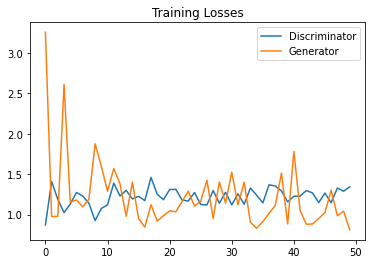

In [37]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training


In [38]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [39]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Một số mẫu từ epoch huấn luyện cuối cùng

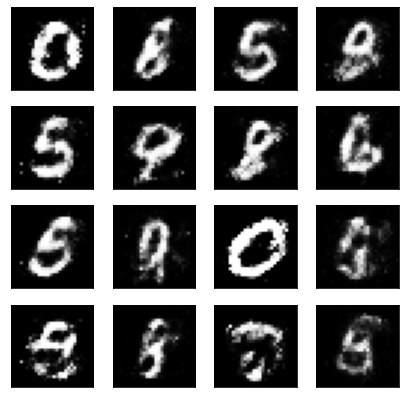

In [40]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Các hình ảnh được tạo khi mạng được huấn luyện tại mỗi 10 epoch

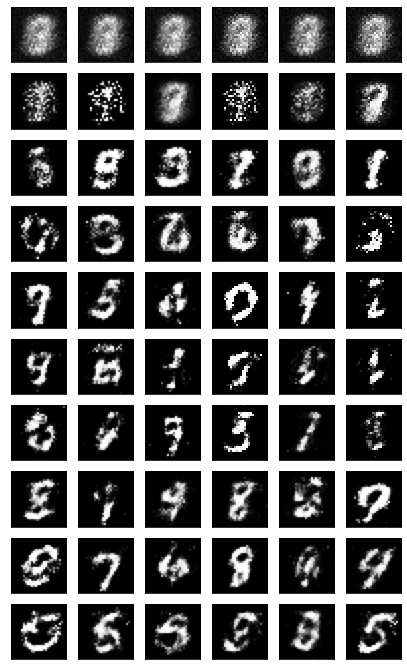

In [41]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sinh mẫu từ generator đã được huấn luyện


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


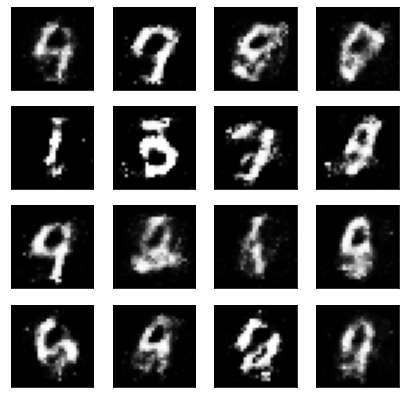

In [42]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])